# LSTM Tutorial
Implementing LSTM based on a tutorial.

In [74]:
from pydantic import BaseModel
import time 
from typing import Optional
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
import os
import pandas as pd
from functools import partial
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime

from dotenv import load_dotenv

In [29]:
!pip install pydantic

     ---------------------------------------- 2.0/2.0 MB 10.4 MB/s eta 0:00:00


In [2]:
load_dotenv()

True

In [61]:
# Data Processing Functions
def load_data_to_df():
    location = f"postgresql://postgres:{os.environ.get('db_password')}@{os.environ.get('db_location')}"
    engine = create_engine(location)
    conn = engine.connect()
    raw_df = pd.read_sql("select * from public.vw_final_dataset where subjectid = 2033176", conn)
    if raw_df.empty:
        raise ValueError("empty df")
    return raw_df

def clean_data(df):
    # Drop rows with no Y value
    df = df.dropna(subset='bg')
    
    # Sort by timestamp
    df = df.sort_values(by="timestamp_clean")
    
    # Set index to time_stamp_clean
    df.index = df['timestamp_clean']
    df = df.drop(labels=['timestamp_clean'], axis=1)
    
    # Drop first row by subject which has data quality issues
    df = df[df.groupby('subjectid').cumcount() > 0] 
    
    # Drop columns that are indices, irrelevant, or capture in OHE variables
    drop_cols = ['subjectid', 'entryid', 'timestamp', 'date', 'time']
    df = df.drop(labels=drop_cols, axis=1)
    
    # Fill nulls (lag BG values) with 0 to indicate data is unavailable
    print(f"Null values to be filled by column:")
    nulls = df.isna().sum()
    null_idx = list(nulls.index)
    vals = list(nulls)
    for col, val in list(zip(null_idx, vals)):
        if val > 0:
            print(col,val)
    df = df.fillna(0)
    
    # One hot Encode Weekdays
    weekdays = np.unique(df['weekday'])
    ohe_weekdays = [f"ohe_{day}" for day in weekdays]
    df[ohe_weekdays] = pd.get_dummies(df.weekday)
    df = df.drop(labels="weekday", axis=1)
    
    return df

def split_and_scale(df):
    # train/val/test split
    train_df = df.loc[df['train_set'] ==1, :]
    val_df = df.loc[df['validation_set'] ==1, :]
    test_df = df.loc[df['test_set'] == 1, :] 
    
    # Extract y vars
    train_y = train_df['bg']
    val_y = val_df['bg']
    test_y = test_df['bg']
    
    # Drop non-X columns
    drop_cols = ['train_set', 'validation_set', 'test_set', 'bg']
    train_df = train_df.drop(labels=drop_cols, axis=1)
    val_df = val_df.drop(labels=drop_cols, axis=1)
    test_df = test_df.drop(labels=drop_cols, axis=1)
    
    # Select Scaling columns (i.e. don't scale one hot encoded variables)
    ohe_cols = train_df.columns[train_df.columns.str.contains('ohe')]
    scaling_cols = train_df.columns.difference(ohe_cols)
    print(f"{len(ohe_cols)} one hot encoded columns ")
    print(f"{len(scaling_cols)} scaled columns")
    
    # Fit Scaler
    scaler = MinMaxScaler()
    scaler.fit(train_df[scaling_cols])
    
    # Perform Scaling 
    train_array = scaler.transform(train_df[scaling_cols])
    val_array = scaler.transform(val_df[scaling_cols])
    test_array = scaler.transform(test_df[scaling_cols])
    
    # Recombine Scaled Data into DataFrame Format 
    train_scaled_df = pd.DataFrame(train_array, columns=scaling_cols, index=train_df.index)
    val_scaled_df = pd.DataFrame(val_array, columns=scaling_cols, index=val_df.index)
    test_scaled_df = pd.DataFrame(test_array, columns=scaling_cols, index=test_df.index)
    
    train_df = pd.concat([train_scaled_df, train_df.loc[:,ohe_cols], train_y], axis=1)
    val_df = pd.concat([val_scaled_df, val_df.loc[:,ohe_cols], val_y], axis=1)
    test_df = pd.concat([test_scaled_df, test_df.loc[:,ohe_cols], test_y], axis=1)
    
#     dataset= DataSet(**{'train_df': train_df,
#                         'val_df': val_df,
#                         'test_df': test_df})
    return train_df, val_df, test_df

def df_to_Xy_tensors(df, window_size=12):
    X = []
    y = []
    num_features = len(df.columns) - 1
    for idx in range(window_size, len(df)-window_size):
        window_df = df.iloc[idx-window_size:idx]
        X.append(window_df.loc[:, df.columns != 'bg'].values)
        # The first element is the y value associated with the sequence of X values 
        y.append(window_df['bg'].iloc[0])
        
    X_tensor = torch.cat([torch.tensor(i).float() for i in X]).view(len(X), window_size, num_features)
    y_tensor = torch.tensor(y).float()
    return X_tensor, y_tensor

In [64]:
print('loading')
raw_df = load_data_to_df()
print('cleaning')
clean_df = clean_data(raw_df)
print("split and scaling")
train_df, val_df, test_df = split_and_scale(clean_df)
print("converting to tensors")
tensorset = TensorSet()
train_X, train_y = df_to_Xy_tensors(train_df, window_size=12)
val_X, val_y = df_to_Xy_tensors(val_df, window_size=12)
test_X, test_y = df_to_Xy_tensors(test_df, window_size=12)

loading
cleaning
Null values to be filled by column:
bg_lag_1 83
bg_lag_2 83
bg_lag_3 85
bg_lag_4 86
bg_lag_5 86
bg_lag_6 88
bg_lag_7 89
bg_lag_8 90
bg_lag_9 91
bg_lag_10 92
bg_lag_11 92
bg_lag_12 94
split and scaling
148 one hot encoded columns 
23 scaled columns
converting to tensors


In [65]:
print(train_X.shape)
train_y.shape

torch.Size([24794, 12, 171])


torch.Size([24794])

In [23]:
raw_df.sort_values('timestamp_clean')['timestamp_clean'].head()

1   2019-01-14 19:51:35.780
2   2019-01-14 19:54:15.583
3   2019-01-14 20:01:34.543
4   2019-01-14 20:06:34.364
5   2019-01-14 20:16:34.036
Name: timestamp_clean, dtype: datetime64[ns]

In [38]:
## Clean Data

def clean_data(df):
    # Drop rows with no Y value
    df = raw_df.dropna(subset='bg')
    
    # Sort by timestamp
    df = df.sort_values(by="timestamp_clean")
    
    # Set index to time_stamp_clean
    df.index = df['timestamp_clean']
    df = df.drop(labels=['timestamp_clean'], axis=1)
    
    # Drop first row by subject which has data quality issues
    df = df[df.groupby('subjectid').cumcount() > 0] 
    df = df.drop(labels=['num_in_group'])
    
    # Drop columns that are indices, irrelevant, or capture in OHE variables
    drop_cols = ['subjectid', 'entryid', 'timestamp', 'date', 'time']
    df = df.drop(labels=drop_cols, axis=1)
    
    # Fill nulls (lag BG values) with 0 to indicate data is unavailable
    print(f"Null values to be filled by column: {df.isna().sum()}")
    df = df.fillna(0)
    
    # One hot Encode Weekdays
    weekdays = np.unique(df['weekday'])
    ohe_weekdays = [f"ohe_{day}" for day in weekdays]
    df[ohe_weekdays] = pd.get_dummies(df.weekday)
    df = df.drop(labels="weekday", axis=1)
    
    return df 
    
# Drop rows with no Y value
df = raw_df.dropna(subset='bg')

# Sort by timestamp
df = df.sort_values(by="timestamp_clean")

# Set index to time_stamp_clean
df.index = df['timestamp_clean']
df = df.drop(labels=['timestamp_clean'], axis=1)

# Drop first row which has data quality issues
df = df.iloc[1:len(df), :] 

# Drop one hot encoded (OHE) columns which contain no relevant information for single subjects
df = df.loc[:, ~df.columns.str.contains('ohe')]

# Drop other columns that contain no relevant info for single subjects
single_subj_drop_cols = ['carbs_datacount', 'normalized_carbs_datapercentile', 'normalized_insulin_datapercentile',
                         'insulin_datacount', 'observations']
df = df.drop(labels=single_subj_drop_cols, axis=1)

# Drop columns that are indices, irrelevant, or capture in OHE variables
drop_cols = ['subjectid', 'entryid', 'timestamp', 'date', 'time']
df = df.drop(labels=drop_cols, axis=1)

# Fill nulls (lag BG values) with 0 to indicate data is unavailable
df = df.fillna(0)

print(f"columns: {df.columns}")
print(f"shape: {df.shape}")
df.head()

columns: Index(['train_set', 'test_set', 'validation_set', 'weekday', 'hour', 'minute',
       'federal_holiday', 'bg', 'insulin', 'carbs',
       'datediff_currentbg_lastbg_inseconds', 'bg_lag_1', 'bg_lag_2',
       'bg_lag_3', 'bg_lag_4', 'bg_lag_5', 'bg_lag_6', 'bg_lag_7', 'bg_lag_8',
       'bg_lag_9', 'bg_lag_10', 'bg_lag_11', 'bg_lag_12'],
      dtype='object')
shape: (54013, 23)


,train_set,test_set,validation_set,weekday,hour,minute,federal_holiday,bg,insulin,carbs,...,bg_lag_3,bg_lag_4,bg_lag_5,bg_lag_6,bg_lag_7,bg_lag_8,bg_lag_9,bg_lag_10,bg_lag_11,bg_lag_12
timestamp_clean,,,,,,,,,,,,,,,,,,,,,
2019-01-14 20:01:34.543,1,0,0,Monday,20.0,1.0,0,211.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-14 20:06:34.364,1,0,0,Monday,20.0,6.0,0,214.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-14 20:16:34.036,1,0,0,Monday,20.0,16.0,0,214.0,0.0,0.0,...,201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-14 20:26:34.794,1,0,0,Monday,20.0,26.0,0,206.0,0.0,0.0,...,211.0,201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-14 20:31:33.834,1,0,0,Monday,20.0,31.0,0,196.0,0.0,0.0,...,214.0,211.0,201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
train_df.columns[list(train_df.columns.str.contains('ohe')).append('bg')]

C:\Users\spenc\AppData\Local\Temp\ipykernel_11176\771581302.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_df.columns[list(train_df.columns.str.contains('ohe')).append('bg')]


array([['weekday', 'hour', 'minute', 'federal_holiday', 'insulin',
        'carbs', 'datediff_currentbg_lastbg_inseconds', 'bg_lag_1',
        'bg_lag_2', 'bg_lag_3', 'bg_lag_4', 'bg_lag_5', 'bg_lag_6',
        'bg_lag_7', 'bg_lag_8', 'bg_lag_9', 'bg_lag_10', 'bg_lag_11',
        'bg_lag_12']], dtype=object)

In [39]:
## Preprocessing 

# train/val/test split
train_df = df.loc[df['train_set'] ==1, :]
val_df = df.loc[df['validation_set'] ==1, :]
test_df = df.loc[df['test_set'] == 1, :] 

# Extract Y vars
train_y = train_df['bg']
val_y = val_df['bg']
test_y = test_df['bg']

# Drop non-X columns
drop_cols = ['train_set', 'validation_set', 'test_set', 'bg']
train_df = train_df.drop(labels=drop_cols, axis=1)
val_df = val_df.drop(labels=drop_cols, axis=1)
test_df = test_df.drop(labels=drop_cols, axis=1)



## Scaling 
# select scaling columns
ohe_cols = train_df.columns[train_df.columns.str.contains('ohe')]
scaling_cols = train_df.columns.difference(ohe_cols)
print(f"one hot encoded columns: {ohe_cols}")
print(f"scaling columns: {scaling_cols}")

scaler = MinMaxScaler()
scaler.fit(train_df[scaling_cols])

train_array = scaler.transform(train_df[scaling_cols])
val_array = scaler.transform(val_df[scaling_cols])
test_array = scaler.transform(test_df[scaling_cols])

train_scaled_df = pd.DataFrame(train_array, columns=scaling_cols, index=train_df.index)
val_scaled_df = pd.DataFrame(val_array, columns=scaling_cols, index=val_df.index)
test_scaled_df = pd.DataFrame(test_array, columns=scaling_cols, index=test_df.index)

train_df = pd.concat([train_scaled_df, train_df.loc[:,ohe_cols], train_y], axis=1)
val_df = pd.concat([val_scaled_df, val_df.loc[:,ohe_cols], val_y], axis=1)
test_df = pd.concat([test_scaled_df, test_df.loc[:,ohe_cols], test_y], axis=1)

train_df.head()

one hot encoded columns: Index([], dtype='object')
scaling columns: Index(['weekday', 'hour', 'minute', 'federal_holiday', 'insulin', 'carbs',
       'datediff_currentbg_lastbg_inseconds', 'bg_lag_1', 'bg_lag_2',
       'bg_lag_3', 'bg_lag_4', 'bg_lag_5', 'bg_lag_6', 'bg_lag_7', 'bg_lag_8',
       'bg_lag_9', 'bg_lag_10', 'bg_lag_11', 'bg_lag_12'],
      dtype='object')


ValueError: could not convert string to float: 'Monday'

In [6]:
# Coerce data to tensor format 
# [tensor([[ 0.5066, -0.4809, -1.4510,  0.3720, -1.3251]])
#[
#  Tensor- [X_1, X_2, ..., X_n]_{t-z}
#  ... 
#  Tensor- [X_1, X_2, ..., X_n]_{t-2}
#  Tensor- [X_1, X_2, ..., X_n]_{t-1}
#]

def df_to_X(df, window_size_hrs=6):
    # Y was extracted earlier...
    X = []
#     y = []
    window_delta = pd.Timedelta(hours=3)
    earliest_time = min(df.index) + window_delta
    latest_time = max(df.index) - window_delta
    i = 0
    for idx in df[earliest_time:latest_time].index:
        window_df = df[idx - window_delta:idx]
#         y.append([float(window_df.loc[idx]['bg'])])
        X.append(window_df.loc[:, df.columns != 'bg'].values)
        i +=1 
    
#     y = np.array(y)
    return X #,y

def df_to_Xy_tensors(df, window_size=12):
    X = []
    y = []
    for idx in range(window_size, len(df)-window_size):
        window_df = df.iloc[idx-window_size:idx]
        X.append(window_df.loc[:, df.columns != 'bg'].values)
        # The first element is the y value associated with the sequence of X values 
        y.append(window_df['bg'].iloc[0])
    return X, y

# train_X = df_to_X(train_df, window_size_hrs=3)
# val_X = df_to_X(val_df, window_size_hrs=3)
# test_X = df_to_X(test_df, window_size_hrs=3)

train_X_seq, train_y_seq = df_to_Xy(train_df, window_size=12)
print(len(train_X_seq), len(train_y_seq))
val_X_seq, val_y_seq = df_to_Xy(val_df, window_size=12)
test_X_seq, test_y_seq = df_to_Xy(test_df, window_size=12)

24794 24794


In [5]:
class Net(nn.Module):
    
    def __init__(self, input_size, hidden_size=8, num_lstm_layers=1, dropout=0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_lstm_layers,
                            dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc1(lstm_out)
        return x

# net = Net(input_size=input_size)
# net

In [75]:
t = datetime.now()
for i in range(10000000):
    pass
datetime.now() - t

datetime.timedelta(microseconds=372403)

In [82]:
def train_lstm(config, checkpoint_dir=None):
    # Configure the network and send it to the device
    # Width of the dataframe - 1 for the y variable 
    
    # Load and clean data
    print('loading')
    raw_df = load_data_to_df()
    
#     engine = create_engine(config['data_loc'])
#     conn = engine.connect()
#     raw_df = pd.read_sql("select * from public.vw_final_dataset where subjectid = 2033176", conn)

    print('cleaning')
    clean_df = clean_data(raw_df)
    print("split and scaling")
    train_df, val_df, test_df = split_and_scale(clean_df)
    # Process data for a given window_size
    print("converting to tensors")
    window_size = config['window_size']
    train_X, train_y = df_to_Xy_tensors(train_df, window_size=window_size)
    val_X, val_y = df_to_Xy_tensors(val_df, window_size=window_size)
    test_X, test_y = df_to_Xy_tensors(test_df, window_size=window_size)
    print("Data processing finished")
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    train_X.to(device)
    train_y.to(device)
    val_X.to(device)
    val_y.to(device)
    
    input_size = train_df.shape[1]-1
    net = Net(input_size=input_size,
              hidden_size=config['hidden_size'],
              num_lstm_layers=config['num_lstm_layers'],
              dropout=config['dropout'])
    
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)     
    net.to(device)
    
    
    optimizer = optim.Adam(net.parameters(), lr=config['learning_rate'])
    
    # Checkpoint Dir Stuff -- handled by Tune 
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, "checkpoint")
        model_state, optimizer_state = torch.load(checkpoint)
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)    
    
    # train
    BATCH_SIZE = config['batch_size']
    for epoch in range(config['epoch']):
        epoch_start = datetime.now()
        print(f"Epoch: {epoch}")
        running_loss = 0
        epoch_steps = 0
        for i in range(0, len(train_X)-BATCH_SIZE, BATCH_SIZE):
            X = train_X[i:i+BATCH_SIZE]
            y = train_y[i:i+BATCH_SIZE]
            net.zero_grad()
            
            out_seq = net(X)
            first_dim, second_dim, _ = out_seq.shape
            pred = out_seq.view(first_dim, second_dim)[:, -1]
            loss = F.mse_loss(pred, y)
            loss.backward()
            
            running_loss += loss.item()
            epoch_steps += 1
            
            # Print loss every 1000 batches
            if i % 1000 == 999:
                avg_loss = running_loss / epoch_steps
                print(f"Epoch {epoch}, steps {epoch_steps-1000}:{epoch_steps} avg loss: {avg_loss}")
                running_loss = 0 
                
        # Validate each epoch
        val_loss = 0
        val_steps = 0
        with torch.no_grad():
            for i in range(0, len(val_X)-BATCH_SIZE, BATCH_SIZE):
                X = val_X[i:i+BATCH_SIZE]
                y = val_y[i:i+BATCH_SIZE]
                out_seq = net(X)
                first_dim, second_dim, _ = out_seq.shape
                pred = out_seq.view(first_dim, second_dim)[:, -1]
                loss = F.mse_loss(pred, y)
                val_loss += loss.item()
                val_steps += 1
        
        with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
            
        tune.report(val_loss=(val_loss/val_steps), train_loss=(running_loss/epoch_steps))
        print(f"Finished epoch {epoch} in {datetime.now()-epoch_start}")
    print("finished!")

In [51]:
import ray

In [89]:
ray.shutdown()
ray.init()

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


Python version:,3.10.1
Ray version:,3.0.0.dev0


In [90]:
config= {
    'hidden_size': tune.sample_from(lambda spec: 2 * np.random.randint(1,2)) ,
    'num_lstm_layers': tune.sample_from(lambda spec: 1 * np.random.randint(1,2)),
    'dropout': tune.sample_from(lambda spec: 0.1 * np.random.randint(0,1)),
    'learning_rate': tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    'window_size': tune.sample_from(lambda spec: 6 * np.random.randint(1,2)),
    'batch_size': tune.sample_from(lambda spec: 8 * np.random.randint(1,2)),
    'epoch': tune.sample_from(lambda spec: 2 * np.random.randint(1,2)),
    'data_loc': f"postgresql://postgres:{os.environ.get('db_password')}@{os.environ.get('db_location')}"
}
scheduler = ASHAScheduler(
    metric="val_loss",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2)

reporter = JupyterNotebookReporter(
    metric_columns = ["val_loss", "loss", "training_iteration"]
)

result= tune.run(
    partial(train_lstm),
    resources_per_trial={"cpu":3},
    config=config,
    num_samples=1,
    progress_reporter=reporter
)

Trial name,status,loc,batch_size,dropout,epoch,hidden_size,learning_rate,num_lstm_layers,window_size,val_loss,training_iteration
train_lstm_06101_00000,TERMINATED,127.0.0.1:25720,8,0,2,2,0.0248484,1,6,17120.2,2


(func pid=25720) loading
(func pid=25720) cleaning
(func pid=25720) Null values to be filled by column:
(func pid=25720) bg_lag_1 83
(func pid=25720) bg_lag_2 83
(func pid=25720) bg_lag_3 85
(func pid=25720) bg_lag_4 86
(func pid=25720) bg_lag_5 86
(func pid=25720) bg_lag_6 88
(func pid=25720) bg_lag_7 89
(func pid=25720) bg_lag_8 90
(func pid=25720) bg_lag_9 91
(func pid=25720) bg_lag_10 92
(func pid=25720) bg_lag_11 92
(func pid=25720) bg_lag_12 94
(func pid=25720) split and scaling
(func pid=25720) 148 one hot encoded columns 
(func pid=25720) 23 scaled columns
(func pid=25720) converting to tensors
(func pid=25720) Data processing finished
(func pid=25720) Epoch: 0
Result for train_lstm_06101_00000:
  date: 2022-07-21_17-14-44
  done: false
  experiment_id: 509709f5c4f84b7fa7c7f238bc871784
  hostname: DESKTOP-LUAPM5T
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 25720
  should_checkpoint: true
  time_since_restore: 47.087101459503174
  time_this_iter_s: 47.0871014595031

(func pid=25720) C:\Users\spenc\AppData\Local\pypoetry\Cache\virtualenvs\bgpredict-zZmw8Ikr-py3.10\lib\site-packages\torch\nn\modules\module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
(func pid=25720)   warnings.warn(


(func pid=25720) Finished epoch 1 in 0:00:04.745428
(func pid=25720) finished!
Result for train_lstm_06101_00000:
  date: 2022-07-21_17-14-49
  done: true
  experiment_id: 509709f5c4f84b7fa7c7f238bc871784
  experiment_tag: 0_batch_size=8,dropout=0.0000,epoch=2,hidden_size=2,learning_rate=0.0248,num_lstm_layers=1,window_size=6
  hostname: DESKTOP-LUAPM5T
  iterations_since_restore: 2
  node_ip: 127.0.0.1
  pid: 25720
  should_checkpoint: true
  time_since_restore: 51.821879863739014
  time_this_iter_s: 4.73477840423584
  time_total_s: 51.821879863739014
  timestamp: 1658438089
  timesteps_since_restore: 0
  train_loss: 19090.785156328755
  training_iteration: 2
  trial_id: '06101_00000'
  val_loss: 17120.19303518827
  warmup_time: 0.0049839019775390625
  


2022-07-21 17:14:49,788	INFO tune.py:737 -- Total run time: 56.52 seconds (56.38 seconds for the tuning loop).
(pid=) [2022-07-21 17:15:30,847 E 21788 29964] (raylet.exe) agent_manager.cc:112: The raylet exited immediately because the Ray agent failed. The raylet fate shares with the agent. This can happen because the Ray agent was unexpectedly killed or failed. See `dashboard_agent.log` for the root cause.
(pid=) [2022-07-21 17:15:32,884 E 6556 20744] (gcs_server.exe) gcs_server.cc:295: Failed to get the resource load: GrpcUnavailable: RPC Error message: failed to connect to all addresses; RPC Error details: 
(pid=) [2022-07-21 17:15:32,884 E 6556 20744] (gcs_server.exe) gcs_server.cc:295: Failed to get the resource load: GrpcUnavailable: RPC Error message: failed to connect to all addresses; RPC Error details: 
(pid=) [2022-07-21 17:15:33,845 E 6556 20744] (gcs_server.exe) gcs_server.cc:295: Failed to get the resource load: GrpcUnavailable: RPC Error message: failed to connect to all

In [96]:
best_trial = result.get_best_trial('val_loss', 'min', 'last')

In [1]:
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))

NameError: name 'best_trial' is not defined

In [113]:
# First try with real data
losses = []
val_losses = []
BATCH_SIZE = 8
optimizer = optim.Adam(net.parameters(), lr=0.01)
iter_idx = 0 
train_X = tensorset.train_X
train_y = tensorset.train_y
for epoch in range(50):
    print(f"Epoch: {epoch}")
    for i in range(0, len(train_X_tens)-BATCH_SIZE, BATCH_SIZE):
        X = train_X[i:i+BATCH_SIZE]
        y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()
        out_seq = net(X)
        break
        first_dim, second_dim, _ = out_seq.shape
        pred = out_seq.view(first_dim, second_dim)[:, -1]
        loss = F.mse_loss(pred, y)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        if iter_idx % 50 == 0:
            with torch.no_grad():
                random_start = np.random.randint(len(val_X_tens)-BATCH_SIZE)
                X = val_X_tens[random_start:random_start+BATCH_SIZE] 
                y = val_y_tens[random_start:random_start+BATCH_SIZE]
                out_seq = net(X)
                first_dim, second_dim, _ = out_seq.shape
                pred = out_seq.view(first_dim, second_dim)[:, -1]
                val_loss = F.mse_loss(pred, y)
                val_losses.append((val_loss, iter_idx))
        iter_idx +=1
        
    print("Loss:", loss)    
    print("val_loss:", val_loss)

Epoch: 0


NameError: name 'loss' is not defined

In [114]:
print(y.shape)
print(X.shape)
print(out_seq.shape)
print(y)
first_dim, second_dim, _ = out_seq.shape
pred = out_seq.view(first_dim, second_dim)[:, -1]
print(pred)

torch.Size([8])
torch.Size([8, 12, 171])
torch.Size([8, 12, 1])
tensor([211., 214., 214., 206., 196., 187., 167., 157.])
tensor([ 0.0354,  0.0035, -0.0315, -0.0402, -0.0322, -0.0221, -0.0262, -0.0298],
       grad_fn=<SelectBackward0>)


In [453]:
val_losses[0:5]
len(losses)

15495

In [469]:
losses_plt = [i.item() for i in losses]
val_losses_vals = [i[0].item() for i in val_losses]
val_losses_idx = [i[1] for i in val_losses]

(0.0, 10000.0)

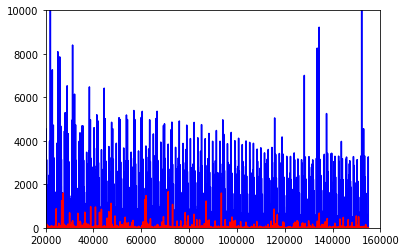

In [474]:
# plt.plot([i[0].item() for i in val_losses])
plt.plot(losses_plt, color='blue')
plt.plot(val_losses_idx, val_losses_vals, color='red')
plt.xlim(20000, 160000)
plt.ylim(0,10000)

In [473]:
np.mean(val_losses_vals)

117.23619236927281

In [407]:
with torch.no_grad():
    out_seq = net(val_X_tens)
    first_dim, second_dim, _ = out_seq.shape
    pred = out_seq.view(first_dim, second_dim)[:, -1]


ValueError: only one element tensors can be converted to Python scalars

In [274]:
print(np.mean(pred))
np.std(pred)

123.05413202953339


38.67697523647435

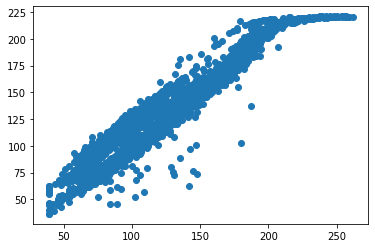

In [282]:
y_plt = [i.item() for i in val_y_tens[1000:5000]]
plt.scatter(y_plt, pred)

In [387]:
preds = net(test[:100])
print(preds)
test[0]

AttributeError: 'list' object has no attribute 'dim'

### Padding
Initial tests showed padding to perform very poorly. Keeping code here in case it's needed in the future

In [159]:
class Padder:
    
    def __init__(self):
        self.max_length = None
        self.padding_array = None

    def fit(self, X):
        # Determine Max Length
        lengths = []
        for i in X:
            lengths.append(len(i))
        min_l = min(lengths)
        self.max_length = max(lengths)
        median_l = np.median(lengths)
        mean_l = np.mean(lengths)
        print(f"Padding up to length {self.max_length}")
        print(f"median length = {median_l}, mean_length = {mean_l}, min_length = {min_l}")
        
        # Create padding array
        feature_width=X[0].shape[1]
        self.padding_array = np.expand_dims(np.zeros(feature_width), axis=0)
        
    
    def transform(self, X):
        # Prepend padding to X
        for idx, i in enumerate(X):
            # Number of arrays to prepend to the existing data
            pad_length = self.max_length - len(i)
            pads = [self.padding_array for _ in range(pad_length)]
            pads.append(i)
            X[idx] = np.concatenate(pads)

        return X 

In [160]:
padder = Padder()
padder.fit(train_X)
train_X_padded = padder.transform(train_X)
val_X_padded = padder.transform(val_X)
test_X_padded = padder.transform(test_X)

Padding up to length 40
median length = 23.0, mean_length = 24.035937815465374, min_length = 1


# Toy Example/Practice Stuff below

In [240]:
# generate fake data
inputs = [torch.randn(1,25) for _ in range(5)]
out = torch.randn(5)
print(out)
inputs[0:2]

tensor([-0.8421, -0.0994, -1.0581,  0.4492, -0.0721])


[tensor([[-0.9606,  1.0944,  1.7780,  1.3661,  1.5622,  0.3268, -0.9777, -1.0041,
           0.5847, -2.3832, -1.1196,  0.7594,  1.7240, -1.2549, -1.0124,  0.2177,
          -1.0469,  0.8911,  0.8690, -1.2307,  0.2678,  0.2080,  0.8018, -2.6957,
           0.5934]]),
 tensor([[-0.2270, -0.7460,  0.0676, -1.2601, -0.3686, -2.3264,  0.5884,  1.2743,
          -0.3886,  1.1344,  1.3895, -0.6844,  1.4866,  0.4065, -0.1946, -0.1110,
           1.9018,  0.3833, -0.0099,  0.8776, -0.1576,  1.5975, -1.4378, -0.5403,
          -0.7007]])]

In [362]:
X[:5]

[array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 1., 39.,  0., ...,  0.,  1.,  0.],
        [ 1., 49.,  0., ...,  0.,  1.,  0.],
        [ 2.,  4.,  0., ...,  0.,  1.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 1., 49.,  0., ...,  0.,  1.,  0.],
        [ 2.,  4.,  0., ...,  0.,  1.,  0.],
        [ 2.,  9.,  0., ...,  0.,  1.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 2.,  4.,  0., ...,  0.,  1.,  0.],
        [ 2.,  9.,  0., ...,  0.,  1.,  0.],
        [ 2., 24.,  0., ...,  0.,  1.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..

In [32]:
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=2)
# five batches of size 3 with 10 elements in each row
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [36]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [37]:
prepare_sequence(training_data[0][0], word_to_ix)

tensor([0, 1, 2, 3, 4])

## Using someone elses example (Not Functional)
First, we'll try to replicate the example used [here](https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7). 

After working with this a bit, it turns out this example was not even close to complete, and I'm not going to spend a ton of effort debugging it.

In [3]:
# Generate Data
N = 100 # number of samples
L = 1000 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)

In [4]:
y.shape

(100, 1000)

In [5]:
# Create LSTM Class
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        outputs, n_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [6]:
a = torch.from_numpy(y[3:, :-1])
b = a.split(1, dim=1)
b[0].shape

torch.Size([97, 1])

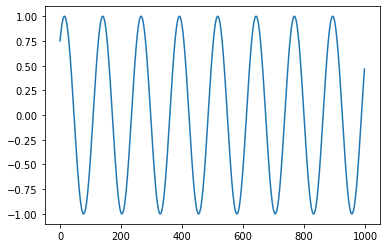

In [7]:
train_input = torch.from_numpy(y[3:, :-1]) # (97, 999)
train_target = torch.from_numpy(y[3:, 1:]) # (97, 999)
test_input = torch.from_numpy(y[:3, :-1]) # (3, 999)
test_target = torch.from_numpy(y[:3, 1:]) # (3, 999)
plt.plot(train_target[4])
plt.show()

In [8]:
model = LSTM()
criterion = nn.MSELoss()
optimiser = optim.LBFGS(model.parameters(), lr=0.08)

In [9]:
def training_loop(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target):
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            loss.backward()
            return loss
        optimiser.step(closure)
        with torch.no_grad():
            future = 1000
            pred = model(test_input, future=future)
            # use all pred samples, but only go to 999
            loss = loss_fn(pred[:, :-future], test_target)
            y = pred.detach().numpy()
        # draw figures
        plt.figure(figsize=(12,6))
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        def draw(yi, colour):
            plt.plot(np.arange(n), yi[:n], colour, linewidth=2.0)
            plt.plot(np.arange(n, n+future), yi[n:], colour+":", linewidth=2.0)
        draw(y[0], 'r')
        draw(y[1], 'b')
        draw(y[2], 'g')
        plt.savefig("predict%d.png"%i, dpi=200)
        plt.close()
        # print the loss
        out = model(train_input)
        loss_print = loss_fn(out, train_target)
        print("Step: {}, Loss: {}".format(i, loss_print))

In [10]:
training_loop(n_epochs = 10,
              model = model,
              optimiser = optimiser,
              loss_fn = criterion,
              train_input = train_input,
              train_target = train_target,
              test_input = test_input,
              test_target = test_target)

NameError: name 'input_t' is not defined